-------- > epoch 1:  erreur quadratique moyenne 0.5300398000507748
-------- > epoch 2:  erreur quadratique moyenne 0.48004742153459945
-------- > epoch 3:  erreur quadratique moyenne 0.47578160292599886
-------- > epoch 4:  erreur quadratique moyenne 0.47474536082646
-------- > epoch 5:  erreur quadratique moyenne 0.4741980226179346
-------- > epoch 6:  erreur quadratique moyenne 0.4737051589754194
-------- > epoch 7:  erreur quadratique moyenne 0.4731392424577784
-------- > epoch 8:  erreur quadratique moyenne 0.47242526904023596
-------- > epoch 9:  erreur quadratique moyenne 0.471486688977377
-------- > epoch 10:  erreur quadratique moyenne 0.4702273199210448
-------- > epoch 11:  erreur quadratique moyenne 0.4685158237044297
-------- > epoch 12:  erreur quadratique moyenne 0.4661591619984294
-------- > epoch 13:  erreur quadratique moyenne 0.46286277528481745
-------- > epoch 14:  erreur quadratique moyenne 0.4581936086383996
-------- > epoch 15:  erreur quadratique moyenne 0.45157

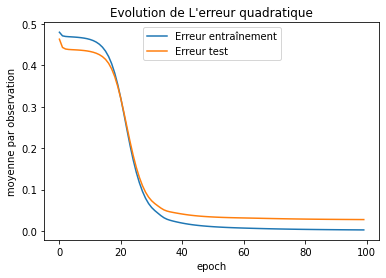

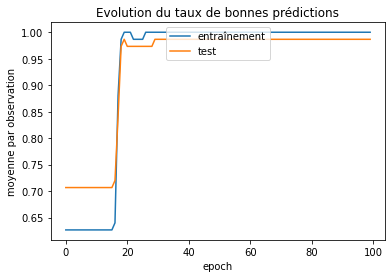

In [3]:
%matplotlib inline
# -*- coding: utf-8 -*-
# Implémentation d'un RNA par couche
# Deux types de couches : dense linéaire et activation
# Division des données en deux groupes : entrainement et test

# Exemple avec Iris

import numpy as np
np.random.seed(42) # pour reproduire les mêmes résultats
import matplotlib.pyplot as plt
import random
random.seed(42)

class Couche:
    """ Classe abstraite qui représente une couche du RNA
        X:  np.array 2D de taille (1,n), entrée de la couche 
        Y: np.array 2D de taille (1,m), sortie de la couche
    """

    def propager_une_couche(self,X):
        """ Calculer la sortie Y pour une valeur de X
        
        X : vecteur des variables prédictives
        Les valeurs de X et Y sont stockées pour les autres traitements.
        """

    def retropropager_une_couche(self,dJ_dY,taux,trace=False):
        """ Calculer les dérivées par rapport à X et les autres paramètres à partir de dJ_dY
        et mettre à jour les paramètres de la couche selon le taux spécifié.
        
        dJ_dY : np.array(1,m), dérivées de J par rapport à la sortie Y
        taux : float, le taux dans la descente de gradiant
        retourne la dérivée de J par rapport à X
        """

class CoucheDenseLineaire(Couche):
    """ Couche linéaire dense. Y=WX+B
    """
    def __init__(self,n,m,init_W=None,init_B=None):
        """ Initilalise les paramètres de la couche. W et B sont initialisés avec init_W et init_B lorsque spécifiés.
        Sinon, des valeurs aléatoires sont générés pour W une distribution normale N(0,1) et B est initialisée avec des 0 
        si les paramètres init_W et init_B ne sont pas spécifiés.
        n : int, taille du vecteur d'entrée X
        m : int, taille du vecteur de sortie Y
        init_W : np.array, shape(n,m), valeur initiale optionnelle de W
        init_B : np.array, shape(1,m), valeur initial optionnelle de B
        """
        if init_W is None :
            self.W = np.random.randn(n,m) 
        else:
            self.W = init_W
        if init_B is None :
            self.B = np.zeros((1,m))
        else:
            self.B = init_B

    def propager_une_couche(self,X):
        """ Fait la propagation de X et retourne Y=WX+B. 
        """
        self.X = X
        self.Y = self.B + np.dot(self.X,self.W)
        return self.Y

    def retropropager_une_couche(self,dJ_dY,taux,trace=False):
        """ Calculer les dérivées dJ_dW,dJ_dB,dJ_dX pour une couche dense linéaire et
        mettre à jour les paramètres selon le taux spécifié
        
        dJ_dY : np.array(1,2), dérivées de J par rapport à la sortie Y
        taux : float, le taux dans la descente de gradiant
        retourne la dérivée de J par rapport à X
        """
        dJ_dW = np.dot(self.X.T,dJ_dY)
        dJ_dB = dJ_dY
        dJ_dX = np.dot(dJ_dY,self.W.T)
        if trace:
            print("dJ_dW:",dJ_dW)
            print("dJ_dB:",dJ_dB)
            print("dJ_dX:",dJ_dX)
        # Metre à jour les paramètres W et B
        self.W -= taux * dJ_dW
        self.B -= taux * dJ_dB
        if trace:
            print("W modifié:",self.W)
            print("B modifié:",self.B)
        return dJ_dX

    
class CoucheActivation(Couche):
    """ Couche d'activation selon une fonction spécifiée dans le constructeur
    """
    def __init__(self,fonction_activation,derivee):
        """ Initialise la fonction_activation ainsi que la dérivée
        fonction_activation: une fonction qui prend chacune des valeurs de X et 
        retourne Y=fonction_activation(X)
        derivee: une fonction qui calcule la dérivée la fonction_activation
        """
        self.fonction_activation = fonction_activation
        self.derivee = derivee

    def propager_une_couche(self,X):
        """ Retourne Y=fonction_activation(X)
        """
        self.X = X
        self.Y = self.fonction_activation(self.X)
        return self.Y

    def retropropager_une_couche(self,dJ_dY,taux,trace=False):
        """ Retourne la dérivée de la fonction d'activation par rapport l'entrée X
        Le taux n'est pas utilisé parce qu'il n'y a pas de paramètres à modifier dans ce genre de couche
        """
        return self.derivee(self.X) * dJ_dY

def erreur_quadratique(y_prediction,y):
    """ Retourne l'erreur quadratique entre la prédiction y_prediction et la valeur attendue y
    """ 
    return np.sum(np.power(y_prediction-y,2))


def d_erreur_quadratique(y_prediction,y):
    return 2*(y_prediction-y)

class ReseauMultiCouches:
    """ Réseau mutli-couche formé par une séquence de Couches
    
    couches : liste de Couches du RNA
    cout : fonction qui calcule de cout J
    derivee_cout: dérivée de la fonction de cout
    """
    def __init__(self):
        self.couches = []
        self.cout = None
        self.derivee_cout = None

    def ajouter_couche(self,couche):
        self.couches.append(couche)

    def specifier_J(self,cout,derivee_cout):
        """ Spécifier la fonction de coût J et sa dérivée
        """
        self.cout = cout
        self.derivee_cout = derivee_cout

    def propagation_donnees_X(self,donnees_X,trace=False):
        """ Prédire Y pour chacune des observations dans donnees_X)
        donnees_X : np.array 3D des valeurs de X pour chacune des observations
            chacun des X est un np.array 2D de taille (1,n)
        """
        nb_observations = len(donnees_X)
        predictions_Y = []
        for indice_observation in range(nb_observations):
            # XY_propage : contient la valeur de X de la couche courante qui correspond 
            # à la valeur de Y de la couche précédente
            XY_propage = donnees_X[indice_observation]
            if trace: 
                print("Valeur de X initiale:",XY_propage)
            for couche in self.couches:
                XY_propage = couche.propager_une_couche(XY_propage)
                if trace: 
                    print("Valeur de Y après propagation pour la couche:",XY_propage)
            predictions_Y.append(XY_propage)

        return predictions_Y

    def metriques(self, donnees_X,donnees_Y):
        """Retourne le cout moyen, la proportion de bons résultats
        Choisit l'indice de la classe dont l'activation est la plus grande"""
        erreur_quadratique = 0
        nb_correct = 0
        predictions_Y=self.propagation_donnees_X(donnees_X)
        for indice in range(len(donnees_Y)):
            erreur_quadratique += self.cout(predictions_Y[indice],donnees_Y[indice])
            classe_predite = np.argmax(predictions_Y[indice])
            if donnees_Y[indice][0,classe_predite] == 1:
                nb_correct+=1
        return (erreur_quadratique/len(donnees_Y),nb_correct/len(donnees_Y))

    def entrainer_descente_gradient_stochastique(self,donnees_ent_X,donnees_ent_Y,donnees_test_X,donnees_test_Y,
                                                 nb_epochs,taux,trace=False,graph_cout=False):
        """ Entrainer le réseau par descente de gradient stochastique (une observation à la fois)
        
        donnees_ent_X : np.array 3D des valeurs de X pour chacune des observations d'entrainement
            chacun des X est un np.array 2D de taille (1,n)
        donnees_ent_Y : np.array 3D des valeurs de Y pour chacune des observations d'entrainement
            chacun des Y est un np.array 2D de taille (1,m)
        donnees_test_X : np.array 3D des valeurs de X pour chacune des observations de test
            chacun des X est un np.array 2D de taille (1,n)
        donnees_test_Y : np.array 3D des valeurs de Y pour chacune des observations de test
            chacun des Y est un np.array 2D de taille (1,m)
        nb_epochs : nombre de cycle de passage sur les données d'entainement
        taux : taux dans la descente de gradiant
        trace : Boolean, True pour afficher une trace des calculs effectués sur les paramètres
        graph_cout : Boolean, True pur afficher un graphique de l'évolution du coût
        """
        nb_observations = len(donnees_ent_X)
        if graph_cout :
            liste_cout_moyen_ent = []
            liste_ok_ent = []
            liste_cout_moyen_test = []
            liste_ok_test = []

        # Boucle d'entrainement principale, nb_epochs fois
        for cycle in range(nb_epochs):
            cout_total = 0
            # Descente de gradiant stochastique, une observation à la fois
            for indice_observation in range(nb_observations):
                # Propagation avant pour une observation X
                # XY_propage : contient la valeur de X de la couche courante qui correspond 
                # à la valeur de Y de la couche précédente
                XY_propage = donnees_ent_X[indice_observation]
                if trace: 
                    print("Valeur de X initiale:",XY_propage)

                for couche in self.couches:
                    XY_propage = couche.propager_une_couche(XY_propage)
                    if trace: 
                        print("Valeur de Y après propagation pour la couche:",XY_propage)

                # Calcul du coût pour une observation
                cout_total += self.cout(XY_propage,donnees_ent_Y[indice_observation])

                # Rétropropagation pour une observation
                # dJ_dX_dJ_dY représente la valeur de la dérivée dJ_dX de la couche suivante
                # qui correspond à dJ_dY de la couche en cours de traitement
                dJ_dX_dJ_dY = self.derivee_cout(XY_propage,donnees_ent_Y[indice_observation])
                if trace :
                    print("dJ_dY pour la couche finale:",dJ_dX_dJ_dY)
                for couche in reversed(self.couches):
                    dJ_dX_dJ_dY = couche.retropropager_une_couche(dJ_dX_dJ_dY,taux,trace)

            # Calculer et afficher le coût moyen pour une epoch
            cout_moyen = cout_total/nb_observations
            if graph_cout:
                print(f'-------- > epoch {cycle+1}:  erreur quadratique moyenne {cout_moyen}')
                cout_ent,ok_ent = self.metriques(donnees_ent_X,donnees_ent_Y)
                cout_test,ok_test = self.metriques(donnees_test_X,donnees_test_Y)
                liste_cout_moyen_ent.append(cout_ent)
                liste_ok_ent.append(ok_ent)
                liste_cout_moyen_test.append(cout_test)
                liste_ok_test.append(ok_test)
                
            
        # Affichage du graphique d'évolution de l'erreur quadratique
        if graph_cout:
            plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
            plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_test,label='Erreur test')
            plt.title("Evolution de L'erreur quadratique")
            plt.xlabel('epoch')
            plt.ylabel('moyenne par observation')
            plt.legend(loc='upper center')
            plt.show()
            
            plt.plot(np.arange(0,nb_epochs),liste_ok_ent,label='entraînement')
            plt.plot(np.arange(0,nb_epochs),liste_ok_test,label='test')
            plt.title("Evolution du taux de bonnes prédictions")
            plt.xlabel('epoch')
            plt.ylabel('moyenne par observation')
            plt.legend(loc='upper center')
            plt.show()

def tanh(x):
    return np.tanh(x)

def derivee_tanh(x):
    return 1-np.tanh(x)**2

def sigmoide(x):
    return 1.0/(1.0+np.exp(-x))

def derivee_sigmoide(x):
    return sigmoide(x)*(1-sigmoide(x))

def bitmap12(classe):
    """ Representer l'entier de classe par un vecteur bitmap (1,2) 
    classe : entier entre 0 et 9 qui représente la classe de l'observation"""
    e = np.zeros((1,2))
    e[0,classe] = 1.0
    return e

def partager(donnees_X,donnees_Y,proportion):
    """ Partager les données X et Y aléatoirement en deux groupes, un pour les
    entrainements et un pour les tests
    proportion : float, proportion des données pour le groupe test
    """
    donnees=[[donnees_X[i],donnees_Y[i]] for i in range(len(donnees_X))]
    random.shuffle(donnees)
    taille_test = int(len(donnees) * proportion)
    donnees_test = donnees[:taille_test]
    donnees_ent = donnees[taille_test:]
    donnees_ent_X = [donnees_ent[i][0] for i in range(len(donnees_ent))]
    donnees_ent_Y = [donnees_ent[i][1] for i in range(len(donnees_ent))]
    donnees_test_X = [donnees_test[i][0] for i in range(len(donnees_test))]
    donnees_test_Y = [donnees_test[i][1] for i in range(len(donnees_test))]
    return  donnees_ent_X,donnees_ent_Y,donnees_test_X,donnees_test_Y
    

# Charger les données de Iris et les convertir dans le format approprié pour ReseauMultiCouches
# Seules les colonnes 1 et 2 sont employées pour la prédiction
from sklearn import datasets
dataset_iris = datasets.load_iris()
donnees_X = dataset_iris.data[:,None,:2]
iris_y = dataset_iris.target
iris_y_setosa = (iris_y==0).astype(int) # setosa ou non
donnees_Y=[bitmap12(iris_y_setosa[i]) for i in range(len(iris_y))]
donnees_ent_X,donnees_ent_Y,donnees_test_X,donnees_test_Y=partager(donnees_X,donnees_Y,0.5)

# Définir l'architecture du RNA 
# Deux couches denses linéaires suivies chacune d'une couche d'activation sigmoide
un_RNA = ReseauMultiCouches()
un_RNA.specifier_J(erreur_quadratique,d_erreur_quadratique)
un_RNA.ajouter_couche(CoucheDenseLineaire(2,5))
un_RNA.ajouter_couche(CoucheActivation(sigmoide,derivee_sigmoide))
un_RNA.ajouter_couche(CoucheDenseLineaire(5,5))
un_RNA.ajouter_couche(CoucheActivation(sigmoide,derivee_sigmoide))
un_RNA.ajouter_couche(CoucheDenseLineaire(5,2))
un_RNA.ajouter_couche(CoucheActivation(sigmoide,derivee_sigmoide))


# Entrainer le RNA Minus
un_RNA.entrainer_descente_gradient_stochastique(donnees_ent_X,donnees_ent_Y,donnees_test_X,donnees_test_Y,
                                                100,0.1,trace = False, graph_cout = True)
